# Loan Application Status Prediction

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from scipy.stats import zscore

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, roc_curve, roc_auc_score
import joblib

import warnings
warnings.filterwarnings('ignore')

In [3]:
data=pd.read_csv('https://raw.githubusercontent.com/dsrscientist/DSData/master/loan_prediction.csv')
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
data.shape

(614, 13)

In [5]:
data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

# Data Cleaning

In [6]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Seven columns having null values:

    * Gender
    * Married
    * Dependents
    * Self_Employed
    * LoanAmount
    * Loan_Amount_Term
    * Credit_History  

In [7]:
data.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

Eight object datatypes are there:

    * Loan_ID               
    * Gender                            
    * Married              
    * Dependents            
    * Education             
    * Self_Employed
    * Property_Area
    * Loan_Status
    
Dependents is not an object data type but it shows ,so we have to check the values of Dependents column. All rest of the columns are okay so that can only be encoded.    

In [8]:
data['Dependents'].unique()

array(['0', '1', '2', '3+', nan], dtype=object)

Encode the values

                                      Fill null values
    
Fill the values of object data type by using mode() and float/int data type by mean()

In [9]:
data['Gender']=data['Gender'].fillna(data['Gender'].mode()[0])
data['Married']=data['Married'].fillna(data['Married'].mode()[0])
data['Dependents']=data['Dependents'].fillna(data['Dependents'].mode()[0])
data['Self_Employed']=data['Self_Employed'].fillna(data['Self_Employed'].mode()[0])
data['LoanAmount']=data['LoanAmount'].fillna(data['LoanAmount'].mean())
data['Loan_Amount_Term']=data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mean())
data['Credit_History']=data['Credit_History'].fillna(data['Credit_History'].mode()[0]) 

In [10]:
data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

Now,there is no null values

In [11]:
data.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

# Visualisation

                                          Visualisation of nominal data

In [12]:
data_nominal=data[['Loan_ID','Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']].copy()
data_nominal.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Status'],
      dtype='object')

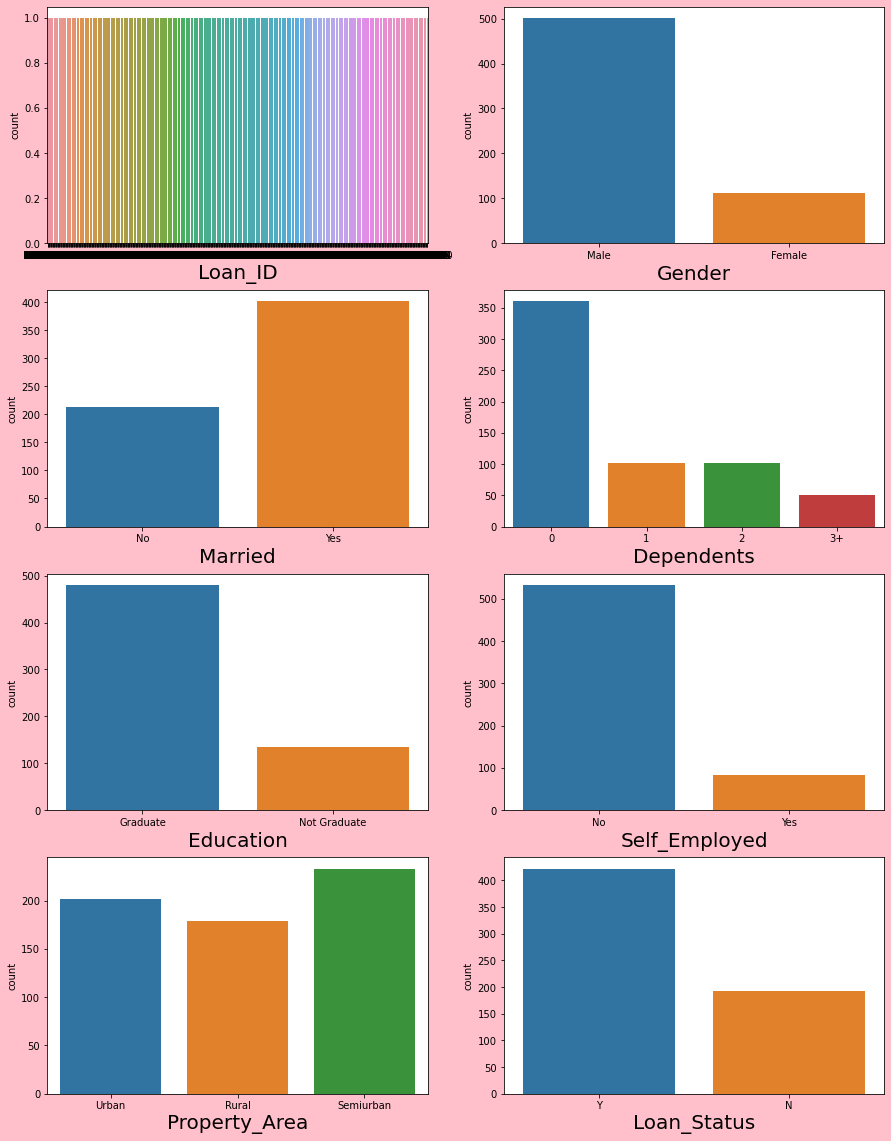

In [13]:
plt.figure(figsize=(15,20),facecolor='pink')
num =1

for column in data_nominal:
    if num <=8:
        ax = plt.subplot(4,2,num)
        sns.countplot(x=column,data=data_nominal)
        plt.xlabel(column,fontsize=20)
        
    num+=1
plt.show()  

In [14]:
data['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

We have to over sample the Loan_Status because No data is less than the Yes data.

                                    Visualisation of continuous data

In [15]:
data_continuous=data[['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History']].copy()
data_continuous.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

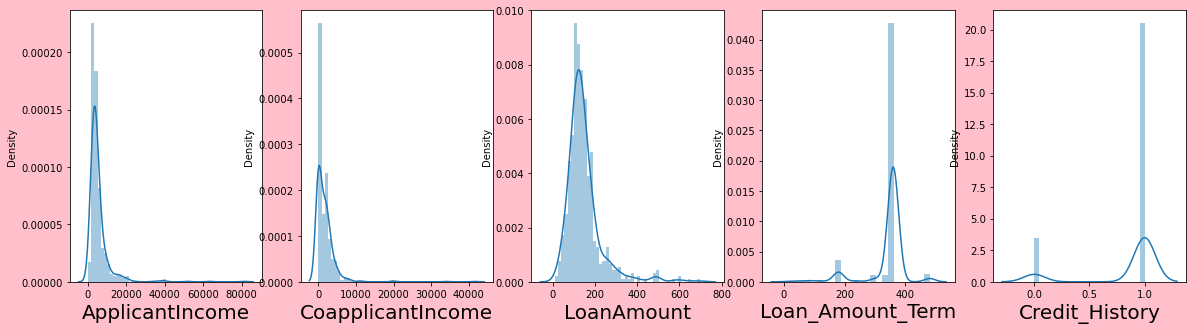

In [16]:
plt.figure(figsize=(20,5),facecolor ='pink')
num =1

for column in data_continuous:
    if num <=5:
        ax = plt.subplot(1,5,num)
        sns.distplot(data_continuous[column])
        plt.xlabel(column,fontsize=20)
        
    num+=1
plt.show()    

                                          Encoding Technique

In [17]:
from sklearn.preprocessing import OrdinalEncoder
enc=OrdinalEncoder()

In [18]:
for i in data.columns:
    if data[i].dtypes=="object":
        data[i]=enc.fit_transform(data[i].values.reshape(-1,1))

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    float64
 1   Gender             614 non-null    float64
 2   Married            614 non-null    float64
 3   Dependents         614 non-null    float64
 4   Education          614 non-null    float64
 5   Self_Employed      614 non-null    float64
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    float64
 12  Loan_Status        614 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 62.5 KB


Now data is in continuous form and may go for analysis process.

In [20]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0.0,1.0,0.0,0.0,0.0,0.0,5849,0.0,146.412162,360.0,1.0,2.0,1.0
1,1.0,1.0,1.0,1.0,0.0,0.0,4583,1508.0,128.000000,360.0,1.0,0.0,0.0
2,2.0,1.0,1.0,0.0,0.0,1.0,3000,0.0,66.000000,360.0,1.0,2.0,1.0
3,3.0,1.0,1.0,0.0,1.0,0.0,2583,2358.0,120.000000,360.0,1.0,2.0,1.0
4,4.0,1.0,0.0,0.0,0.0,0.0,6000,0.0,141.000000,360.0,1.0,2.0,1.0


# Analysis

In [21]:
data.describe()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,306.500000,0.817590,0.653094,0.744300,0.218241,0.133550,5403.459283,1621.245798,146.412162,342.000000,0.855049,1.037459,0.687296
std,177.390811,0.386497,0.476373,1.009623,0.413389,0.340446,6109.041673,2926.248369,84.037468,64.372489,0.352339,0.787482,0.463973
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000,0.000000,0.000000
25%,153.250000,1.000000,0.000000,0.000000,0.000000,0.000000,2877.500000,0.000000,100.250000,360.000000,1.000000,0.000000,0.000000
50%,306.500000,1.000000,1.000000,0.000000,0.000000,0.000000,3812.500000,1188.500000,129.000000,360.000000,1.000000,1.000000,1.000000
75%,459.750000,1.000000,1.000000,1.000000,0.000000,0.000000,5795.000000,2297.250000,164.750000,360.000000,1.000000,2.000000,1.000000
max,613.000000,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,41667.000000,700.000000,480.000000,1.000000,2.000000,1.000000


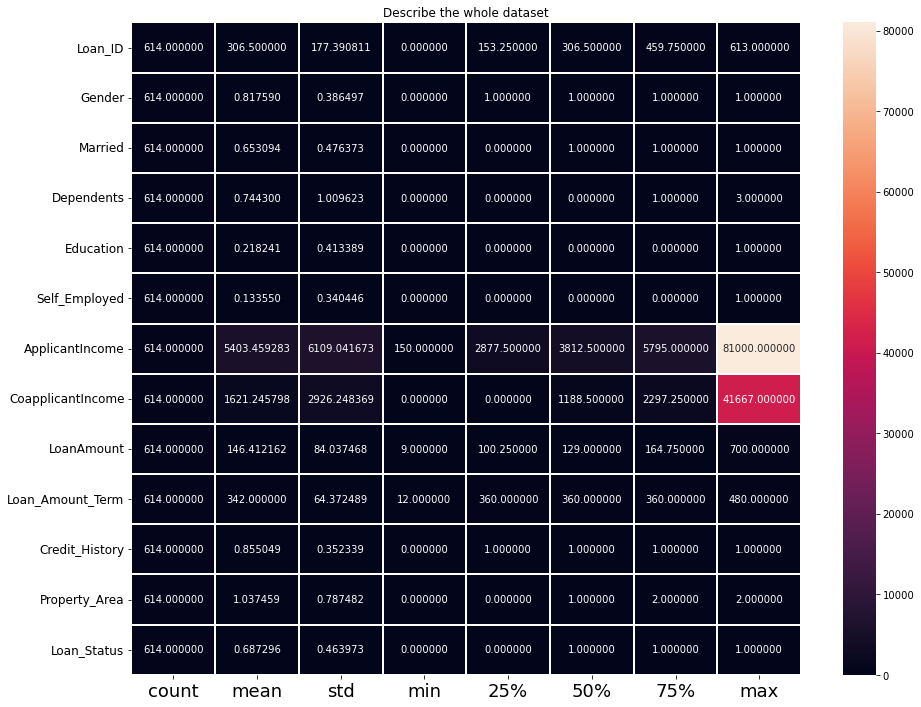

In [22]:
plt.figure(figsize=(15,12))
sns.heatmap(data.describe().transpose(),linewidth=2,annot=True,fmt='f')
plt.xticks(fontsize=18)
plt.yticks(fontsize=12)
plt.title("Describe the whole dataset")
plt.show()

There is no null values.

The number of rows and columns are:
    
    rows    = 614
    columns = 13
    
The mean,standard deviation,minimum and maximum values are:
    
    * Loan_ID    
              mean = 306.50
              std = 177.39
              minimum = 0.00
              maximum = 613.00
              
    * Gender     
              mean = 0.81
              std = 0.38
              minimum = 0.00
              maximum = 1.00
              
    * Married           
              mean = 0.65 
              std = 0.48
              minimum = 0.00
              maximum = 1.00
              
    * Dependents
              mean = 0.74
              std = 1.00
              minimum = 0.00
              maximum = 3.00
              
    * Education 
              mean = 0.22
              std = 0.41
              minimum = 0.00
              maximum = 1.00
              
    * Self_Employed
              mean = 0.13
              std = 0.34
              minimum = 0.00
              maximum = 1.00
              
    * ApplicantIncome
              mean = 5403.45
              std = 6109.04
              minimum = 150.00
              maximum = 81000.00
              
    * CoapplicantIncome 
              mean = 1621.24
              std = 2926.25
              minimum = 0.00
              maximum = 41667.00
               
    * LoanAmount
              mean = 146.41
              std = 84.03
              minimum = 9.00
              maximum = 700.00
              
    * Loan_Amount_Term
              mean = 342.00
              std = 64.37
              minimum = 12.00
              maximum = 480.00
              
    * Credit_History
              mean = 0.85
              std = 0.35
              minimum = 0.00
              maximum = 1.00
              
    * Property_Area
              mean = 1.03
              std = 0.79
              minimum = 0.00
              maximum = 2.00

                                            Correlation

In [23]:
data.corr()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,1.000000,-0.028029,-0.016013,0.051559,0.039442,0.032874,0.016925,0.039211,0.035684,-0.028945,-0.030603,-0.155416,0.011773
Gender,-0.028029,1.000000,0.364569,0.172914,0.045364,-0.000525,0.058809,0.082912,0.107930,-0.073567,0.009170,-0.025752,0.017987
Married,-0.016013,0.364569,1.000000,0.334216,0.012304,0.004489,0.051708,0.075948,0.147141,-0.100863,0.010938,0.004257,0.091478
Dependents,0.051559,0.172914,0.334216,1.000000,0.055752,0.056798,0.118202,0.030430,0.163106,-0.101054,-0.040160,-0.000244,0.010118
Education,0.039442,0.045364,0.012304,0.055752,1.000000,-0.010383,-0.140760,-0.062290,-0.166998,-0.077242,-0.073658,-0.065243,-0.085884
Self_Employed,0.032874,-0.000525,0.004489,0.056798,-0.010383,1.000000,0.127180,-0.016100,0.115260,-0.033943,-0.001550,-0.030860,-0.003700
ApplicantIncome,0.016925,0.058809,0.051708,0.118202,-0.140760,0.127180,1.000000,-0.116605,0.565620,-0.045242,-0.018615,-0.009500,-0.004710
CoapplicantIncome,0.039211,0.082912,0.075948,0.030430,-0.062290,-0.016100,-0.116605,1.000000,0.187828,-0.059675,0.011134,0.010522,-0.059187
LoanAmount,0.035684,0.107930,0.147141,0.163106,-0.166998,0.115260,0.565620,0.187828,1.000000,0.038801,-0.001431,-0.044776,-0.036416
Loan_Amount_Term,-0.028945,-0.073567,-0.100863,-0.101054,-0.077242,-0.033943,-0.045242,-0.059675,0.038801,1.000000,0.000432,-0.077620,-0.020974


<AxesSubplot:>

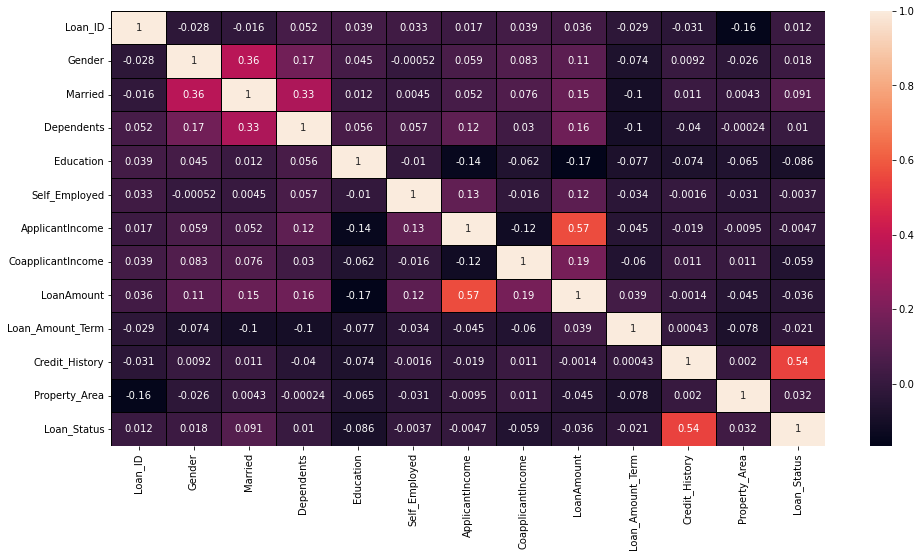

In [24]:
plt.figure(figsize=(16,8))
sns.heatmap(data.corr(),annot=True,linewidth=0.5,linecolor='black')

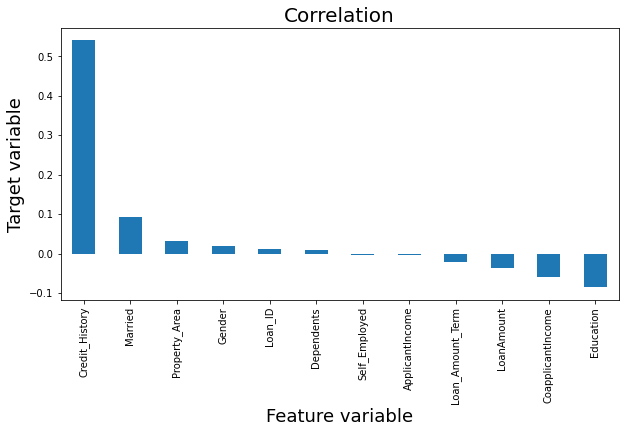

In [25]:
plt.figure(figsize=(10,5))
data.corr()['Loan_Status'].sort_values(ascending=False).drop(['Loan_Status']).plot(kind='bar')
plt.xlabel('Feature variable',fontsize=18)
plt.ylabel('Target variable',fontsize=18)
plt.title('Correlation',fontsize=20)
plt.show()

Loan_ID, Gender, Married, Dependents, CoapplicantIncome, LoanAmount, Credit_History, Property_Area are positive correlated with
target variable.
Education, Self_Employed,ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term are positive correlated with target
variable.

The correlation of feature variable with the target variable :
    
    * Loan_ID has 1% of correlation with target variable              
    * Gender has 1% of correlation with target variable                             
    * Married has 9% of correlation with target variable              
    * Dependents has 1% of correlation with target variable            
    * Education has 8% of correlation with target variable              
    * Self_Employed has 0% of correlation with target variable 
    * ApplicantIncome has 0% of correlation with target variable 
    * CoapplicantIncome has 5% of correlation with target variable 
    * LoanAmount has 3% of correlation with target variable 
    * Loan_Amount_Term has 2% of correlation with target variable 
    * Credit_History has 54% of correlation with target variable 
    * Property_Area has 3% of correlation with target variable 
   

                                Check the columns have higher relation

Relation b/w ApplicantIncome and LoanAmount


<AxesSubplot:xlabel='ApplicantIncome', ylabel='LoanAmount'>

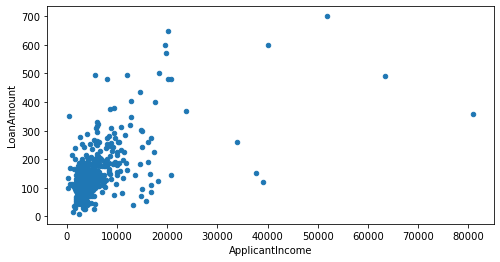

In [26]:
print("Relation b/w ApplicantIncome and LoanAmount")
data.plot(kind='scatter', x='ApplicantIncome', y='LoanAmount',figsize=(8,4))

Most of the applicant whose income is 0 to 20000 ,they take a loan upto 500. After 20000 the loan is very less(upto 5%).
It means that if the income is higher and higher the chances of taking loan may decrease.

Relation b/w Credit_History and Loan_Status


<AxesSubplot:xlabel='Credit_History', ylabel='Loan_Status'>

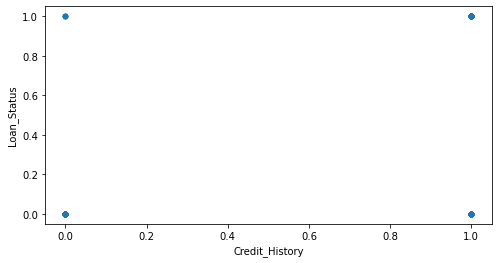

In [27]:
print("Relation b/w Credit_History and Loan_Status")
data.plot(kind='scatter', x='Credit_History', y='Loan_Status',figsize=(8,4))

Here is the four categories which we get by both the varaibles :
    
* previously never took a loan nor this time 
* previously never took a loan but this time I take a loan
* previously took a loan but not this time 
* previously took a loan and this time again take a loan

                                              Outliers

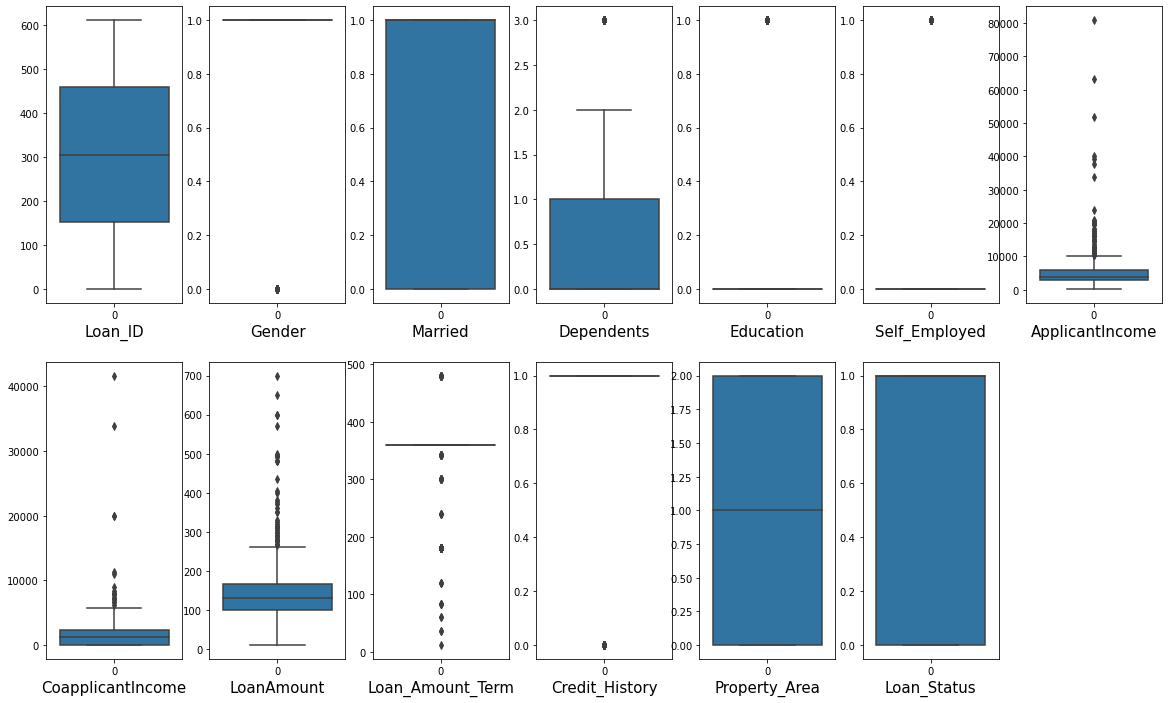

In [28]:
plt.figure(figsize=(20,12))
number = 1

for column in data:
    if number <=13:
        plt.subplot(2,7,number)
        ax = sns.boxplot(data=data[column])
        plt.xlabel(column,fontsize=15)
       
    number+=1
plt.show()    

Outliers are present in the columns:

    * ApplicantIncome     
    * CoapplicantIncome    
    * LoanAmount           
    * Loan_Amount_Term    
    * Credit_History 

In [29]:
data.skew()

Loan_ID              0.000000
Gender              -1.648795
Married             -0.644850
Dependents           1.015551
Education            1.367622
Self_Employed        2.159796
ApplicantIncome      6.539513
CoapplicantIncome    7.491531
LoanAmount           2.726601
Loan_Amount_Term    -2.389680
Credit_History      -2.021971
Property_Area       -0.066196
Loan_Status         -0.809998
dtype: float64

Take threshold range for skewness is (-0.5,0.5).

Skewness present in the columns:

    * ApplicantIncome     
    * CoapplicantIncome    
    * LoanAmount           
    * Loan_Amount_Term    
    * Credit_History 

                                    Variance Inflation Factor

In [30]:
x=data.drop(['Loan_Status'],axis=1)
y=data['Loan_Status']

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

In [31]:
vif=pd.DataFrame()
vif['VIF']=[variance_inflation_factor(x_scaled,i)for i in  range(x_scaled.shape[1])]
vif['Input']= x.columns
vif

,VIF,Input
0,3.748411,Loan_ID
1,5.995113,Gender
2,3.652944,Married
3,1.799868,Dependents
4,1.316173,Education
5,1.178299,Self_Employed
6,2.819461,ApplicantIncome
7,1.485678,CoapplicantIncome
8,6.262249,LoanAmount
9,11.230384,Loan_Amount_Term


There are four columns having VIF greater than 5. 

We drop one column with highest VIF value and then check again until we get less than 5 for each column. Consider upto four
columns only.
So,we drop Loan_Amount_Term from data.

In [32]:
data=data.drop(['Loan_Amount_Term'],axis=1)

In [33]:
x=data.drop(['Loan_Status'],axis=1)
y=data['Loan_Status']

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

vif=pd.DataFrame()
vif['VIF']=[variance_inflation_factor(x_scaled,i)for i in  range(x_scaled.shape[1])]
vif['Input']= x.columns
vif

,VIF,Input
0,3.315619,Loan_ID
1,5.532661,Gender
2,3.648790,Married
3,1.795419,Dependents
4,1.300725,Education
5,1.177983,Self_Employed
6,2.808079,ApplicantIncome
7,1.481427,CoapplicantIncome
8,5.808972,LoanAmount
9,4.813623,Credit_History


Now drop LoanAmount column

In [34]:
data=data.drop(['LoanAmount'],axis=1)

In [35]:
x=data.drop(['Loan_Status'],axis=1)
y=data['Loan_Status']

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

vif=pd.DataFrame()
vif['VIF']=[variance_inflation_factor(x_scaled,i)for i in  range(x_scaled.shape[1])]
vif['Input']= x.columns
vif

,VIF,Input
0,3.245445,Loan_ID
1,5.435738,Gender
2,3.603428,Married
3,1.785131,Dependents
4,1.296877,Education
5,1.172671,Self_Employed
6,1.804889,ApplicantIncome
7,1.344193,CoapplicantIncome
8,4.658108,Credit_History
9,2.390595,Property_Area


Now drop last column having higher VIF that is Gender

In [36]:
data=data.drop(['Gender'],axis=1)

In [37]:
x=data.drop(['Loan_Status'],axis=1)
y=data['Loan_Status']

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

vif=pd.DataFrame()
vif['VIF']=[variance_inflation_factor(x_scaled,i)for i in  range(x_scaled.shape[1])]
vif['Input']= x.columns
vif

,VIF,Input
0,3.145110,Loan_ID
1,3.006463,Married
2,1.778726,Dependents
3,1.273250,Education
4,1.172381,Self_Employed
5,1.768666,ApplicantIncome
6,1.327031,CoapplicantIncome
7,4.202473,Credit_History
8,2.341973,Property_Area


Now there is no multicollinearity exist

                                      Removing Outliers

In [38]:
x=data.drop(['Loan_Status'],axis=1)
y=data['Loan_Status']

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

In [39]:
z=np.abs(zscore(x))

threshold=3

print(np.where(z>3))

(array([  9, 126, 155, 171, 177, 183, 185, 333, 402, 409, 417, 443, 581,
       600], dtype=int64), array([6, 5, 5, 5, 6, 5, 5, 5, 6, 5, 6, 5, 6, 6], dtype=int64))


Outliers are present in the continuous data so we drop those raws from the data.

In [40]:
data_new=data[(z<3).all(axis=1)]

In [41]:
print("Old data frame:",data.shape)
print("New data frame:",data_new.shape)
print("Total dropped rows:",data.shape[0]-data_new.shape[0])

Old data frame: (614, 10)
New data frame: (600, 10)
Total dropped rows: 14


In [42]:
loss_percentage=(614-600)/614*100
print(loss_percentage,'%')

2.2801302931596092 %


There is not too mush loss on removing the outliers,so we can remove.

<AxesSubplot:>

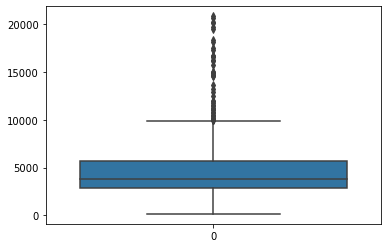

In [43]:
sns.boxplot(data=data_new['ApplicantIncome'])

<AxesSubplot:>

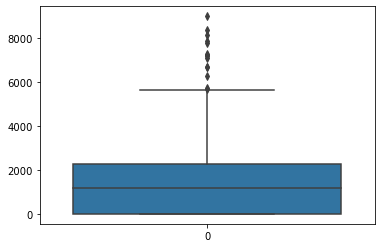

In [44]:
sns.boxplot(data=data_new['CoapplicantIncome'])

                                           Removing Skewness

In [45]:
data_new['ApplicantIncome']=np.sqrt(data_new['ApplicantIncome'])
data_new['CoapplicantIncome']=np.sqrt(data_new['CoapplicantIncome'])

In [46]:
data_new.skew()

Loan_ID             -0.005164
Married             -0.638260
Dependents           1.038991
Education            1.331927
Self_Employed        2.162688
ApplicantIncome      1.366087
CoapplicantIncome    0.246148
Credit_History      -2.040802
Property_Area       -0.059082
Loan_Status         -0.832158
dtype: float64

Still skewness is present in the ApplicantIncome column.

<AxesSubplot:xlabel='ApplicantIncome', ylabel='Density'>

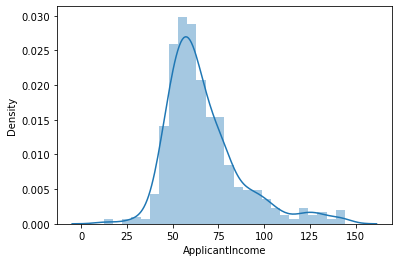

In [47]:
sns.distplot(data_new['ApplicantIncome'])

<AxesSubplot:xlabel='CoapplicantIncome', ylabel='Density'>

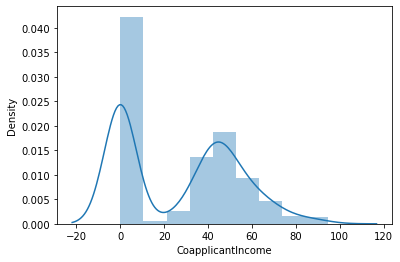

In [48]:
sns.distplot(data_new['CoapplicantIncome'])

In [49]:
data_new=data_new.drop(['ApplicantIncome'],axis=1)
data_new.head()

,Loan_ID,Married,Dependents,Education,Self_Employed,CoapplicantIncome,Credit_History,Property_Area,Loan_Status
0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,2.0,1.0
1,1.0,1.0,1.0,0.0,0.0,38.832976,1.0,0.0,0.0
2,2.0,1.0,0.0,0.0,1.0,0.000000,1.0,2.0,1.0
3,3.0,1.0,0.0,1.0,0.0,48.559242,1.0,2.0,1.0
4,4.0,0.0,0.0,0.0,0.0,0.000000,1.0,2.0,1.0


# Model Testing

                                    Over Sampling of Imbalanced data

In [50]:
x=data_new.drop('Loan_Status',axis=1)
y=data_new['Loan_Status']

In [51]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

In [52]:
!pip install imbalanced-learn

In [53]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [54]:
x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,test_size = 0.75,random_state =41)

In [55]:
print("The no. classes before fit {}".format(Counter(y_train)))

The no. classes before fit Counter({1.0: 102, 0.0: 48})


In [56]:
Oversample=SMOTE(0.75)
x_train_ns,y_train_ns=Oversample.fit_resample(x_train,y_train)

In [57]:
print("The no. classes after fit {}".format(Counter(y_train_ns)))

The no. classes after fit Counter({1.0: 102, 0.0: 76})


                                          Logistic Regression

In [58]:
lr=LogisticRegression()

In [59]:
for i in range(0,100):
    x_train_ns,x_test_ns,y_train_ns,y_test_ns = train_test_split(x_scaled,y,test_size = 0.20,random_state = i)
    lr.fit(x_train_ns,y_train_ns)
    pred_train=lr.predict(x_train_ns)
    pred_test=lr.predict(x_test_ns)
    print("The model perform very well")
    print("random state",i)
    print("Training accuracy score:",accuracy_score(y_train_ns,pred_train)*100)
    print("Testing accuracy score:",accuracy_score(y_test_ns,pred_test)*100)
    print('\n')

The model perform very well
random state 0
Training accuracy score: 82.29166666666666
Testing accuracy score: 78.33333333333333


The model perform very well
random state 1
Training accuracy score: 80.83333333333333
Testing accuracy score: 84.16666666666667


The model perform very well
random state 2
Training accuracy score: 81.04166666666667
Testing accuracy score: 83.33333333333334


The model perform very well
random state 3
Training accuracy score: 82.5
Testing accuracy score: 77.5


The model perform very well
random state 4
Training accuracy score: 80.0
Testing accuracy score: 87.5


The model perform very well
random state 5
Training accuracy score: 81.45833333333333
Testing accuracy score: 81.66666666666667


The model perform very well
random state 6
Training accuracy score: 81.04166666666667
Testing accuracy score: 83.33333333333334


The model perform very well
random state 7
Training accuracy score: 80.625
Testing accuracy score: 85.0


The model perform very well
random s

In [60]:
x_train_ns,x_test_ns,y_train_ns,y_test_ns = train_test_split(x_scaled,y, test_size=0.20,random_state=84) 

In [61]:
lr.fit(x_train_ns,y_train_ns)
y_pred = lr.predict(x_test_ns)
accuracy = accuracy_score(y_test_ns,y_pred)*100
print("accuracy score:",accuracy)

accuracy score: 89.16666666666667


In [62]:
cm= confusion_matrix(y_test_ns,y_pred)
print(cm)

[[20 11]
 [ 2 87]]


In [63]:
clr=classification_report(y_test_ns,y_pred)
print(clr)

              precision    recall  f1-score   support

         0.0       0.91      0.65      0.75        31
         1.0       0.89      0.98      0.93        89

    accuracy                           0.89       120
   macro avg       0.90      0.81      0.84       120
weighted avg       0.89      0.89      0.89       120



In [64]:
for j in range(2,10):
    cv_score=cross_val_score(lr,x_scaled,y,cv=j)
    cv_mean=cv_score.mean()
    print(f"At cross fold {j} the cv score is {cv_mean}")
    print("\n")

At cross fold 2 the cv score is 0.815


At cross fold 3 the cv score is 0.815


At cross fold 4 the cv score is 0.8150000000000001


At cross fold 5 the cv score is 0.8150000000000001


At cross fold 6 the cv score is 0.815


At cross fold 7 the cv score is 0.8150674223177642


At cross fold 8 the cv score is 0.815


At cross fold 9 the cv score is 0.8151414643951957




In [65]:
lrscore=cross_val_score(lr,x_scaled,y,cv=9)
lrc=lrscore.mean()
print('cross val score:',lrc*100)

cross val score: 81.51414643951958


                                        K Neighbors Classifier

In [66]:
knn= KNeighborsClassifier()

In [67]:
for i in range(0,100):
    x_train_ns,x_test_ns,y_train_ns,y_test_ns = train_test_split(x_scaled,y,test_size = 0.20,random_state = i)
    knn.fit(x_train_ns,y_train_ns)
    pred_train=knn.predict(x_train_ns)
    pred_test=knn.predict(x_test_ns)
    print("The model perform very well")
    print("random state",i)
    print("Training accuracy score:",accuracy_score(y_train_ns,pred_train)*100)
    print("Testing accuracy score:",accuracy_score(y_test_ns,pred_test)*100)
    print('\n')

The model perform very well
random state 0
Training accuracy score: 84.375
Testing accuracy score: 76.66666666666667


The model perform very well
random state 1
Training accuracy score: 82.70833333333333
Testing accuracy score: 80.83333333333333


The model perform very well
random state 2
Training accuracy score: 84.375
Testing accuracy score: 80.0


The model perform very well
random state 3
Training accuracy score: 84.58333333333333
Testing accuracy score: 75.83333333333333


The model perform very well
random state 4
Training accuracy score: 81.875
Testing accuracy score: 80.0


The model perform very well
random state 5
Training accuracy score: 82.91666666666667
Testing accuracy score: 79.16666666666666


The model perform very well
random state 6
Training accuracy score: 83.125
Testing accuracy score: 80.0


The model perform very well
random state 7
Training accuracy score: 83.125
Testing accuracy score: 85.0


The model perform very well
random state 8
Training accuracy score:

In [68]:
x_train_ns,x_test_ns,y_train_ns,y_test_ns = train_test_split(x_scaled,y, test_size=0.20,random_state=68)  

In [69]:
knn.fit(x_train_ns,y_train_ns)
y_pred = knn.predict(x_test_ns)

accuracy = accuracy_score(y_test_ns,y_pred)*100
print("accuracy score:",accuracy)

accuracy score: 87.5


In [70]:
cm= confusion_matrix(y_test_ns,y_pred)
print(cm)

[[17 11]
 [ 4 88]]


In [71]:
clr=classification_report(y_test_ns,y_pred)
print(clr)

              precision    recall  f1-score   support

         0.0       0.81      0.61      0.69        28
         1.0       0.89      0.96      0.92        92

    accuracy                           0.88       120
   macro avg       0.85      0.78      0.81       120
weighted avg       0.87      0.88      0.87       120



In [72]:
for j in range(2,10):
    cv_score=cross_val_score(knn,x_scaled,y,cv=j)
    cv_mean=cv_score.mean()
    print(f"At cross fold {j} the cv score is {cv_mean}")
    print("\n")

At cross fold 2 the cv score is 0.7933333333333333


At cross fold 3 the cv score is 0.795


At cross fold 4 the cv score is 0.77


At cross fold 5 the cv score is 0.7816666666666667


At cross fold 6 the cv score is 0.79


At cross fold 7 the cv score is 0.7750635137776041


At cross fold 8 the cv score is 0.7866666666666666


At cross fold 9 the cv score is 0.7735062063420273




In [73]:
knnscore=cross_val_score(knn,x_scaled,y,cv=2)
knnc=knnscore.mean()
print('cross val score:',knnc*100)

cross val score: 79.33333333333333


                                            Decision Tree Classifier

In [74]:
clf=DecisionTreeClassifier()

In [75]:
for i in range(0,100):
    x_train_ns,x_test_ns,y_train_ns,y_test_ns = train_test_split(x_scaled,y,test_size = 0.20,random_state = i)
    clf.fit(x_train_ns,y_train_ns)
    pred_train=clf.predict(x_train_ns)
    pred_test=clf.predict(x_test_ns)
    print("The model perform very well")
    print("random state",i)
    print("Training accuracy score:",round(accuracy_score(y_train_ns,pred_train)*100,1))
    print("Testing accuracy score:",round(accuracy_score(y_test_ns,pred_test)*100,1))
    print('\n')

The model perform very well
random state 0
Training accuracy score: 100.0
Testing accuracy score: 69.2


The model perform very well
random state 1
Training accuracy score: 100.0
Testing accuracy score: 68.3


The model perform very well
random state 2
Training accuracy score: 100.0
Testing accuracy score: 70.0


The model perform very well
random state 3
Training accuracy score: 100.0
Testing accuracy score: 68.3


The model perform very well
random state 4
Training accuracy score: 100.0
Testing accuracy score: 75.0


The model perform very well
random state 5
Training accuracy score: 100.0
Testing accuracy score: 69.2


The model perform very well
random state 6
Training accuracy score: 100.0
Testing accuracy score: 75.8


The model perform very well
random state 7
Training accuracy score: 100.0
Testing accuracy score: 73.3


The model perform very well
random state 8
Training accuracy score: 100.0
Testing accuracy score: 67.5


The model perform very well
random state 9
Training acc

In [76]:
x_train_ns,x_test_ns,y_train_ns,y_test_ns = train_test_split(x_scaled,y,test_size = 0.20,random_state = 20)

In [77]:
clf.fit(x_train_ns,y_train_ns)
y_pred = clf.predict(x_test_ns)

accuracy = accuracy_score(y_test_ns,y_pred)*100
print("accuracy score:",accuracy)

accuracy score: 77.5


In [78]:
cm= confusion_matrix(y_test_ns,y_pred)
print(cm)

[[29 17]
 [10 64]]


In [79]:
clr=classification_report(y_test_ns,y_pred)
print(clr)

              precision    recall  f1-score   support

         0.0       0.74      0.63      0.68        46
         1.0       0.79      0.86      0.83        74

    accuracy                           0.78       120
   macro avg       0.77      0.75      0.75       120
weighted avg       0.77      0.78      0.77       120



In [80]:
for j in range(2,10):
    cv_score=cross_val_score(clf,x_scaled,y,cv=j)
    cv_mean=cv_score.mean()
    print(f"At cross fold {j} the cv score is {cv_mean}")
    print("\n")

At cross fold 2 the cv score is 0.5


At cross fold 3 the cv score is 0.57


At cross fold 4 the cv score is 0.565


At cross fold 5 the cv score is 0.665


At cross fold 6 the cv score is 0.6333333333333334


At cross fold 7 the cv score is 0.6434434238811804


At cross fold 8 the cv score is 0.6283333333333333


At cross fold 9 the cv score is 0.6450575405799286




In [81]:
clfscore=cross_val_score(clf,x_scaled,y,cv=5)
clfc=clfscore.mean()
print('cross val score:',clfc*100)

cross val score: 67.83333333333334


                                     Random Forest Classifier

In [82]:
rfc=RandomForestClassifier()

In [83]:
for i in range(0,100):
    x_train_ns,x_test_ns,y_train_ns,y_test_ns = train_test_split(x_scaled,y,test_size = 0.20,random_state = i)
    rfc.fit(x_train_ns,y_train_ns)
    pred_train=rfc.predict(x_train_ns)
    pred_test=rfc.predict(x_test_ns)
    print("The model perform very well")
    print("random state",i)
    print("Training accuracy score:",accuracy_score(y_train_ns,pred_train)*100)
    print("Testing accuracy score:",accuracy_score(y_test_ns,pred_test)*100)
    print('\n')

The model perform very well
random state 0
Training accuracy score: 100.0
Testing accuracy score: 75.83333333333333


The model perform very well
random state 1
Training accuracy score: 100.0
Testing accuracy score: 78.33333333333333


The model perform very well
random state 2
Training accuracy score: 100.0
Testing accuracy score: 75.0


The model perform very well
random state 3
Training accuracy score: 100.0
Testing accuracy score: 75.0


The model perform very well
random state 4
Training accuracy score: 100.0
Testing accuracy score: 80.83333333333333


The model perform very well
random state 5
Training accuracy score: 100.0
Testing accuracy score: 74.16666666666667


The model perform very well
random state 6
Training accuracy score: 100.0
Testing accuracy score: 82.5


The model perform very well
random state 7
Training accuracy score: 100.0
Testing accuracy score: 85.0


The model perform very well
random state 8
Training accuracy score: 100.0
Testing accuracy score: 77.5


The

In [84]:
x_train_ns,x_test_ns,y_train_ns,y_test_ns = train_test_split(x_scaled,y,test_size = 0.20,random_state = 82)

In [85]:
rfc.fit(x_train_ns,y_train_ns)
y_pred = rfc.predict(x_test_ns)

accuracy = accuracy_score(y_test_ns,y_pred)*100
print("accuracy score:",accuracy)

accuracy score: 85.0


In [86]:
cm= confusion_matrix(y_test_ns,y_pred)
print(cm)

[[18 12]
 [ 6 84]]


In [87]:
clr=classification_report(y_test_ns,y_pred)
print(clr)

              precision    recall  f1-score   support

         0.0       0.75      0.60      0.67        30
         1.0       0.88      0.93      0.90        90

    accuracy                           0.85       120
   macro avg       0.81      0.77      0.78       120
weighted avg       0.84      0.85      0.84       120



In [88]:
for j in range(2,10):
    cv_score=cross_val_score(rfc,x_scaled,y,cv=j)
    cv_mean=cv_score.mean()
    print(f"At cross fold {j} the cv score is {cv_mean}")
    print("\n")

At cross fold 2 the cv score is 0.665


At cross fold 3 the cv score is 0.6316666666666667


At cross fold 4 the cv score is 0.7233333333333333


At cross fold 5 the cv score is 0.7783333333333334


At cross fold 6 the cv score is 0.68


At cross fold 7 the cv score is 0.7019542700801251


At cross fold 8 the cv score is 0.7033333333333334


At cross fold 9 the cv score is 0.7237800894517312




In [89]:
rfcscore=cross_val_score(rfc,x_scaled,y,cv=5)
rfcc=rfcscore.mean()
print('cross val score:',rfcc*100)

cross val score: 77.33333333333334


                                                SVC

In [90]:
svc=SVC()

In [91]:
for i in range(0,100):
    x_train_ns,x_test_ns,y_train_ns,y_test_ns = train_test_split(x_scaled,y,test_size = 0.20,random_state = i)
    svc.fit(x_train_ns,y_train_ns)
    pred_train=svc.predict(x_train_ns)
    pred_test=svc.predict(x_test_ns)
    print("The model perform very well")
    print("random state",i)
    print("Training accuracy score:",accuracy_score(y_train_ns,pred_train)*100)
    print("Testing accuracy score:",accuracy_score(y_test_ns,pred_test)*100)
    print('\n')

The model perform very well
random state 0
Training accuracy score: 82.29166666666666
Testing accuracy score: 78.33333333333333


The model perform very well
random state 1
Training accuracy score: 80.83333333333333
Testing accuracy score: 84.16666666666667


The model perform very well
random state 2
Training accuracy score: 81.04166666666667
Testing accuracy score: 83.33333333333334


The model perform very well
random state 3
Training accuracy score: 82.5
Testing accuracy score: 77.5


The model perform very well
random state 4
Training accuracy score: 80.0
Testing accuracy score: 87.5


The model perform very well
random state 5
Training accuracy score: 81.45833333333333
Testing accuracy score: 81.66666666666667


The model perform very well
random state 6
Training accuracy score: 81.04166666666667
Testing accuracy score: 83.33333333333334


The model perform very well
random state 7
Training accuracy score: 80.625
Testing accuracy score: 85.0


The model perform very well
random s

In [92]:
x_train_ns,x_test_ns,y_train_ns,y_test_ns = train_test_split(x_scaled,y,test_size = 0.20,random_state = 84) 

In [93]:
svc.fit(x_train_ns,y_train_ns)
y_pred = svc.predict(x_test_ns)
accuracy = accuracy_score(y_test_ns,y_pred)*100
print("accuracy score:",accuracy)

accuracy score: 89.16666666666667


In [94]:
cm= confusion_matrix(y_test_ns,y_pred)
print(cm)

[[20 11]
 [ 2 87]]


In [95]:
clr=classification_report(y_test_ns,y_pred)
print(clr)

              precision    recall  f1-score   support

         0.0       0.91      0.65      0.75        31
         1.0       0.89      0.98      0.93        89

    accuracy                           0.89       120
   macro avg       0.90      0.81      0.84       120
weighted avg       0.89      0.89      0.89       120



In [96]:
for j in range(2,10):
    cv_score=cross_val_score(svc,x_scaled,y,cv=j)
    cv_mean=cv_score.mean()
    print(f"At cross fold {j} the cv score is {cv_mean}")
    print("\n")

At cross fold 2 the cv score is 0.815


At cross fold 3 the cv score is 0.815


At cross fold 4 the cv score is 0.8150000000000001


At cross fold 5 the cv score is 0.8150000000000001


At cross fold 6 the cv score is 0.815


At cross fold 7 the cv score is 0.8150674223177642


At cross fold 8 the cv score is 0.815


At cross fold 9 the cv score is 0.8151414643951957




In [97]:
svcscore=cross_val_score(svc,x_scaled,y,cv=9)
svcc=svcscore.mean()
print('cross val score:',svcc*100)

cross val score: 81.51414643951958


The accuracy_score and cv_score of all the models:

    * Logistic Regression
        accuracy_score: 89.16
        cv_score: 81.51

    * K Neighbors Classifier
        accuracy_score: 87.5
        cv_score: 79.33

    * Decision Tree Classifier
        accuracy_score: 77.5
        cv_score: 67.83

    * Random Forest Classifier
        accuracy_score: 85.0
        cv_score: 77.83

    * SVC
        accuracy_score: 89.16
        cv_score: 81.51
            
All the model gives better result but there are two models Logistic Regresssion and SVC have higher as well as same score.So, we go with any one of the model. I prefer Logistic Regression for Hyper parameter tuning.       

                                    Hyper Parameter Tuning

In [119]:
lr=LogisticRegression()

In [120]:
parameters={'penalty' : ['l1','l2','elasticent','none'],
           'solver'  : ['newton-cg','lbfgs','liblinear','sag'],
           'C'       : [1000,100,10,1.0,0.1,0.01],
           'max_iter': [1,2,3,4,5,6,7,8,9,10,11,12]}

In [121]:
GCV=GridSearchCV(lr,parameters,cv=9,n_jobs=-1)
GCV.fit(x_train_ns,y_train_ns)
GCV.best_params_

{'C': 1000, 'max_iter': 11, 'penalty': 'l2', 'solver': 'lbfgs'}

In [123]:
clf = LogisticRegression(C=1000, max_iter=11, penalty='l2', solver='lbfgs')
clf.fit(x_train_ns,y_train_ns)
pred = clf.predict(x_test_ns)
accuracy_score(y_test_ns,pred)*100

89.16666666666667

accuracy score is 89.17,but after hyper parameter tuning the accuracy score is still 89.17
So, the accuracy score= 89.17

                                   Plot ROC_AUC curve and AUC_score

In [124]:
fpr,tpr,thresholds = roc_curve(y_test_ns,pred) 

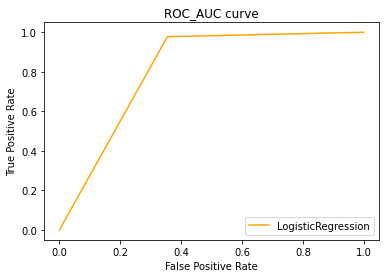

AUC_score 81.13446901051105


In [125]:
plt.plot(fpr,tpr,color='orange',label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_AUC curve')
plt.legend()                                                                                 
plt.show()

auc_score = roc_auc_score(y_test_ns,pred)*100
print("AUC_score",auc_score)

Accuracy score is better than the AUC score.
    accuracy_score=89.17
    AUC_score=81.13     

                                               Save file

In [126]:
joblib.dump(GCV.best_params_,"LoanApplicationPrediction.pkl")

['LoanApplicationPrediction.pkl']

                                             Conclusion 

In [127]:
Prediction=pd.DataFrame({'Actual data':y_test_ns,"Predicted data":pred})
Prediction

,Actual data,Predicted data
50,1.0,1.0
436,1.0,1.0
593,1.0,1.0
549,1.0,1.0
150,0.0,0.0
...,...,...
182,1.0,1.0
587,1.0,1.0
563,1.0,1.0
279,1.0,1.0
